In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kaggle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression, Lasso,Ridge,ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from statsmodels.stats.outliers_influence import variance_inflation_factor


import warnings
warnings.filterwarnings('ignore')


import joblib

In [2]:
kaggle.api.authenticate()
kaggle.api.dataset_download_files('mohannapd/mobile-price-prediction',unzip=True,path="./datasets")

Dataset URL: https://www.kaggle.com/datasets/mohannapd/mobile-price-prediction


In [3]:
data = pd.read_csv('datasets/Cellphone.csv')
data.head(3) # Display first 3 rows of the dataset

,Product_id,Price,Sale,weight,resoloution,ppi,cpu core,cpu freq,internal mem,ram,RearCam,Front_Cam,battery,thickness
0,203,2357,10,135.0,5.2,424,8,1.35,16.0,3.0,13.00,8.0,2610,7.4
1,880,1749,10,125.0,4.0,233,2,1.30,4.0,1.0,3.15,0.0,1700,9.9
2,40,1916,10,110.0,4.7,312,4,1.20,8.0,1.5,13.00,5.0,2000,7.6


In [4]:
df = data.copy() # Create a copy of the dataset

In [5]:
df.columns # Display the columns of the dataset

Index(['Product_id', 'Price', 'Sale', 'weight', 'resoloution', 'ppi',
       'cpu core', 'cpu freq', 'internal mem', 'ram', 'RearCam', 'Front_Cam',
       'battery', 'thickness'],
      dtype='object')

In [6]:
df.drop(columns=['Product_id'], inplace=True) # Drop the 'Product_id' column as it is not needed for analysis

In [7]:
df.describe().T # Display the summary statistics of the dataset

,count,mean,std,min,25%,50%,75%,max
Price,161.0,2215.596273,768.187171,614.0,1734.0,2258.00,2744.000,4361.0
Sale,161.0,621.465839,1546.618517,10.0,37.0,106.00,382.000,9807.0
weight,161.0,170.426087,92.888612,66.0,134.1,153.00,170.000,753.0
resoloution,161.0,5.209938,1.509953,1.4,4.8,5.15,5.500,12.2
ppi,161.0,335.055901,134.826659,121.0,233.0,294.00,428.000,806.0
cpu core,161.0,4.857143,2.444016,0.0,4.0,4.00,8.000,8.0
cpu freq,161.0,1.502832,0.599783,0.0,1.2,1.40,1.875,2.7
internal mem,161.0,24.501714,28.804773,0.0,8.0,16.00,32.000,128.0
ram,161.0,2.204994,1.609831,0.0,1.0,2.00,3.000,6.0
RearCam,161.0,10.378261,6.181585,0.0,5.0,12.00,16.000,23.0


In [8]:
df.info() # Display information about the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Price         161 non-null    int64  
 1   Sale          161 non-null    int64  
 2   weight        161 non-null    float64
 3   resoloution   161 non-null    float64
 4   ppi           161 non-null    int64  
 5   cpu core      161 non-null    int64  
 6   cpu freq      161 non-null    float64
 7   internal mem  161 non-null    float64
 8   ram           161 non-null    float64
 9   RearCam       161 non-null    float64
 10  Front_Cam     161 non-null    float64
 11  battery       161 non-null    int64  
 12  thickness     161 non-null    float64
dtypes: float64(8), int64(5)
memory usage: 16.5 KB


In [9]:
df.duplicated().sum() # Check for duplicate rows in the dataset

np.int64(0)

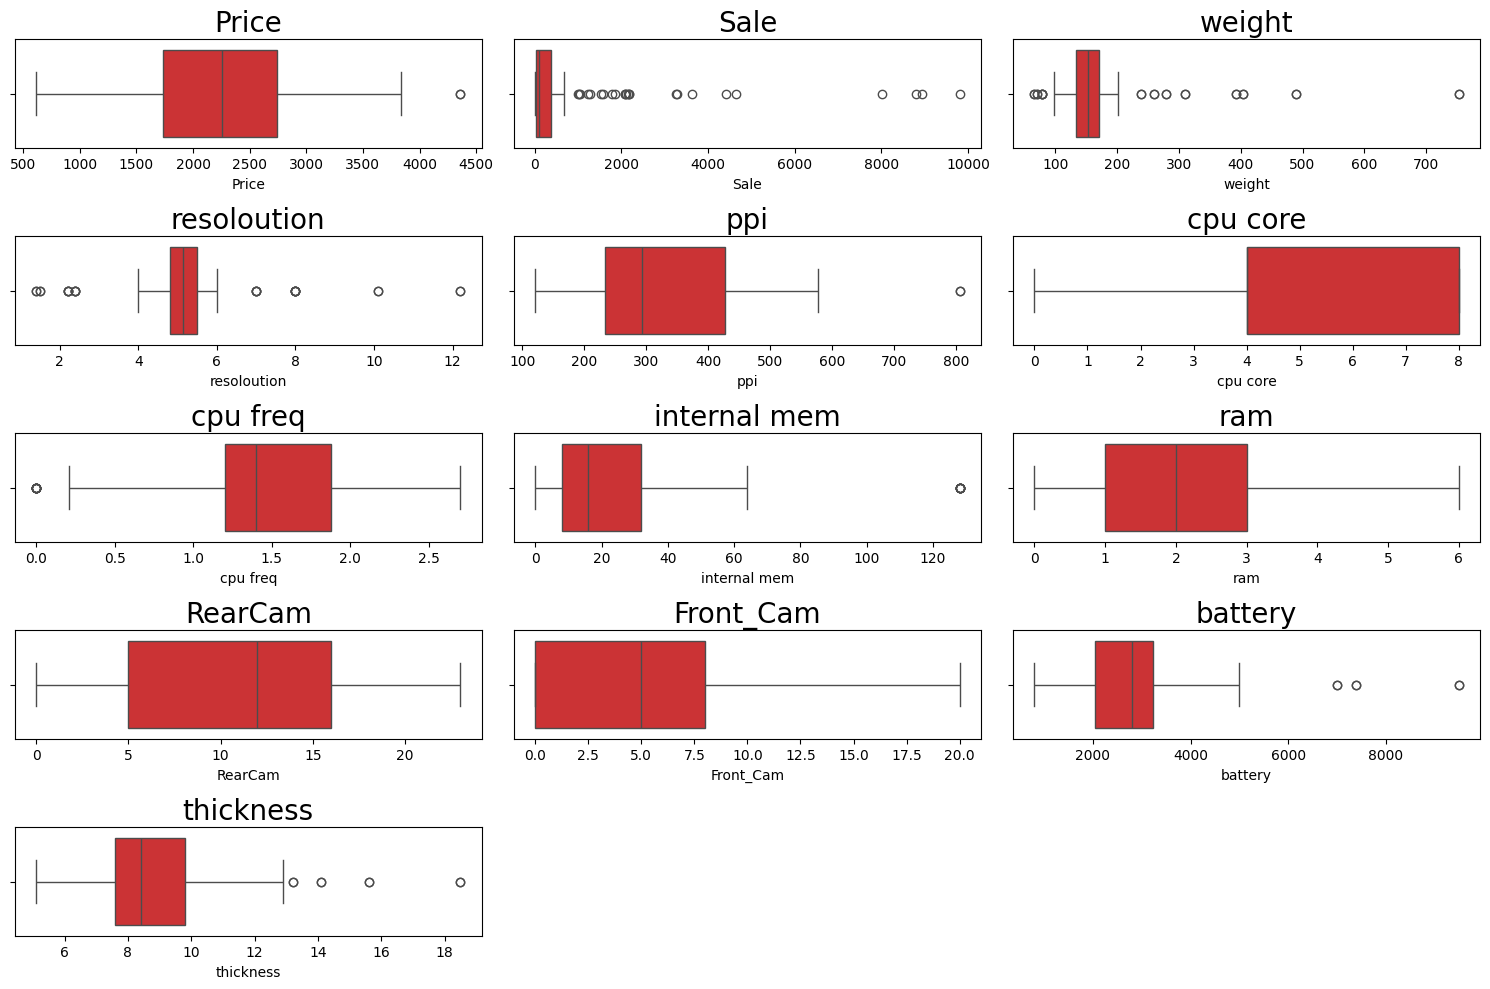

In [10]:
num_col = len(df.columns)
cols_per_row = 3
rows = int(np.ceil(num_col / cols_per_row))

fig,axes = plt.subplots(nrows=rows, ncols=cols_per_row,figsize=(15,2*rows))

axes= axes.flatten()

for i,col in enumerate(df.columns):
    sns.boxplot(df[col],ax=axes[i],orient='h', palette='Set1')
    axes[i].set_title(col, fontsize=20)

for j in range(i+1, len(axes)):
    axes[j].axis('off')  # Hide unused subplots

plt.tight_layout()
plt.show()

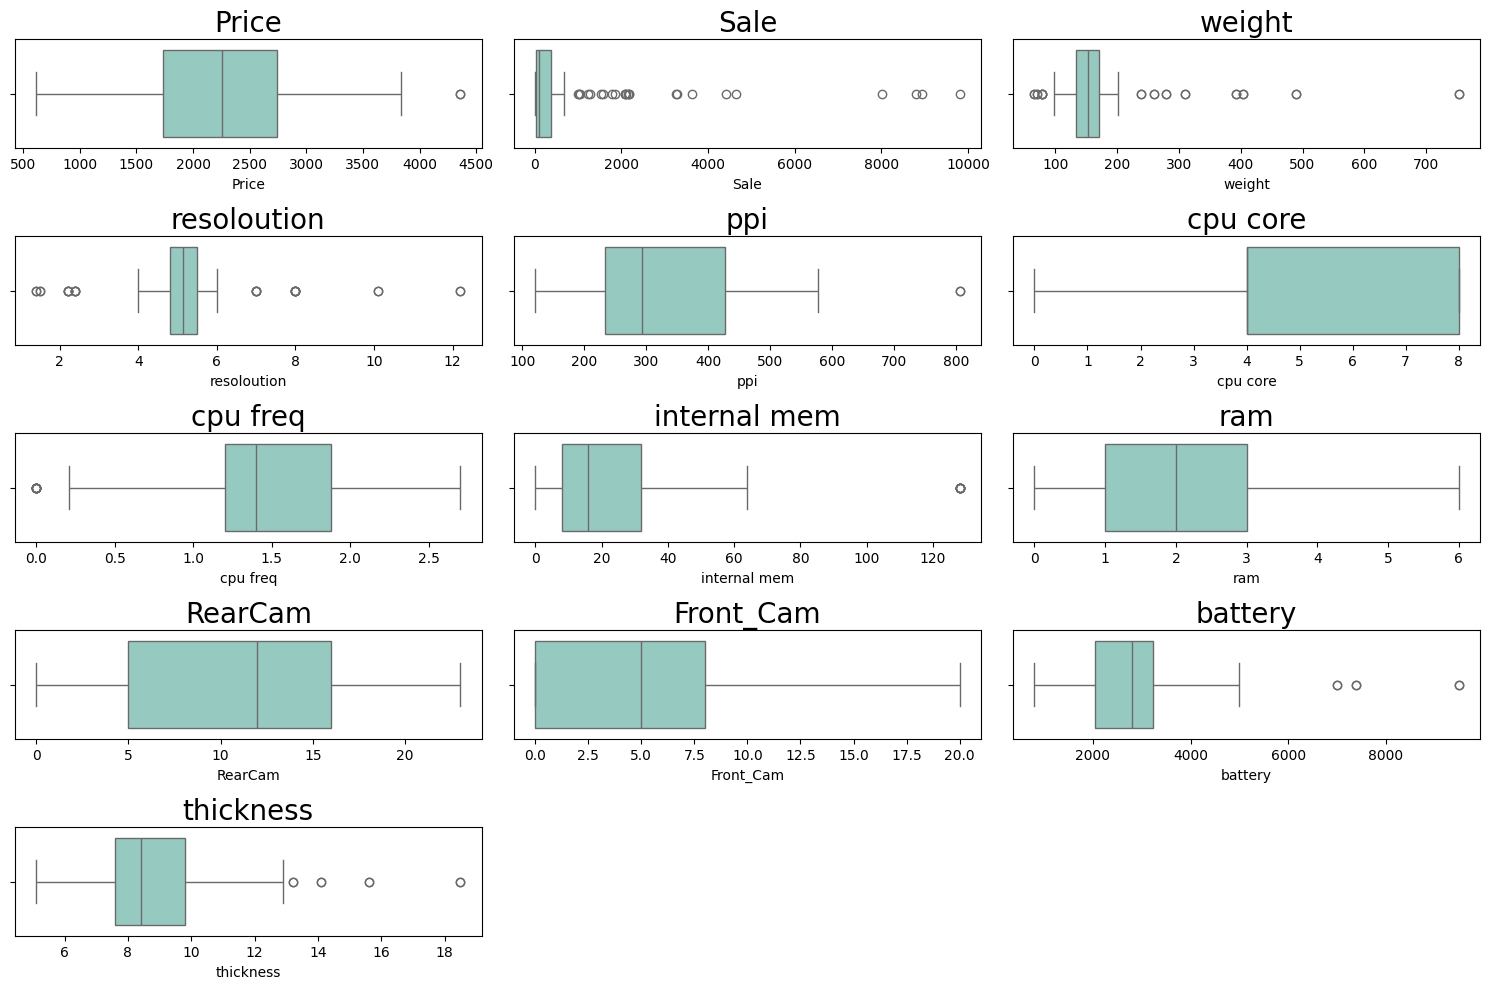

In [11]:
num_col = len(df.columns)
cols_per_row = 3
rows = int(np.ceil(num_col / cols_per_row))

fig,axes = plt.subplots(nrows=rows, ncols=cols_per_row,figsize=(15,2*rows))

axes= axes.flatten()

for i,col in enumerate(df.columns):
    sns.boxplot(df[col],ax=axes[i],orient='h', palette='Set3')
    axes[i].set_title(col, fontsize=20)

for j in range(i+1, len(axes)):
    axes[j].axis('off')  # Hide unused subplots

plt.tight_layout()
plt.show()

In [12]:
skewed_cols=[]
for col in df.columns:
    if abs(df[col].skew()>1):
        skewed_cols.append(col)
print("Skewed Columns:", skewed_cols)

Skewed Columns: ['Sale', 'weight', 'resoloution', 'internal mem', 'Front_Cam', 'battery', 'thickness']


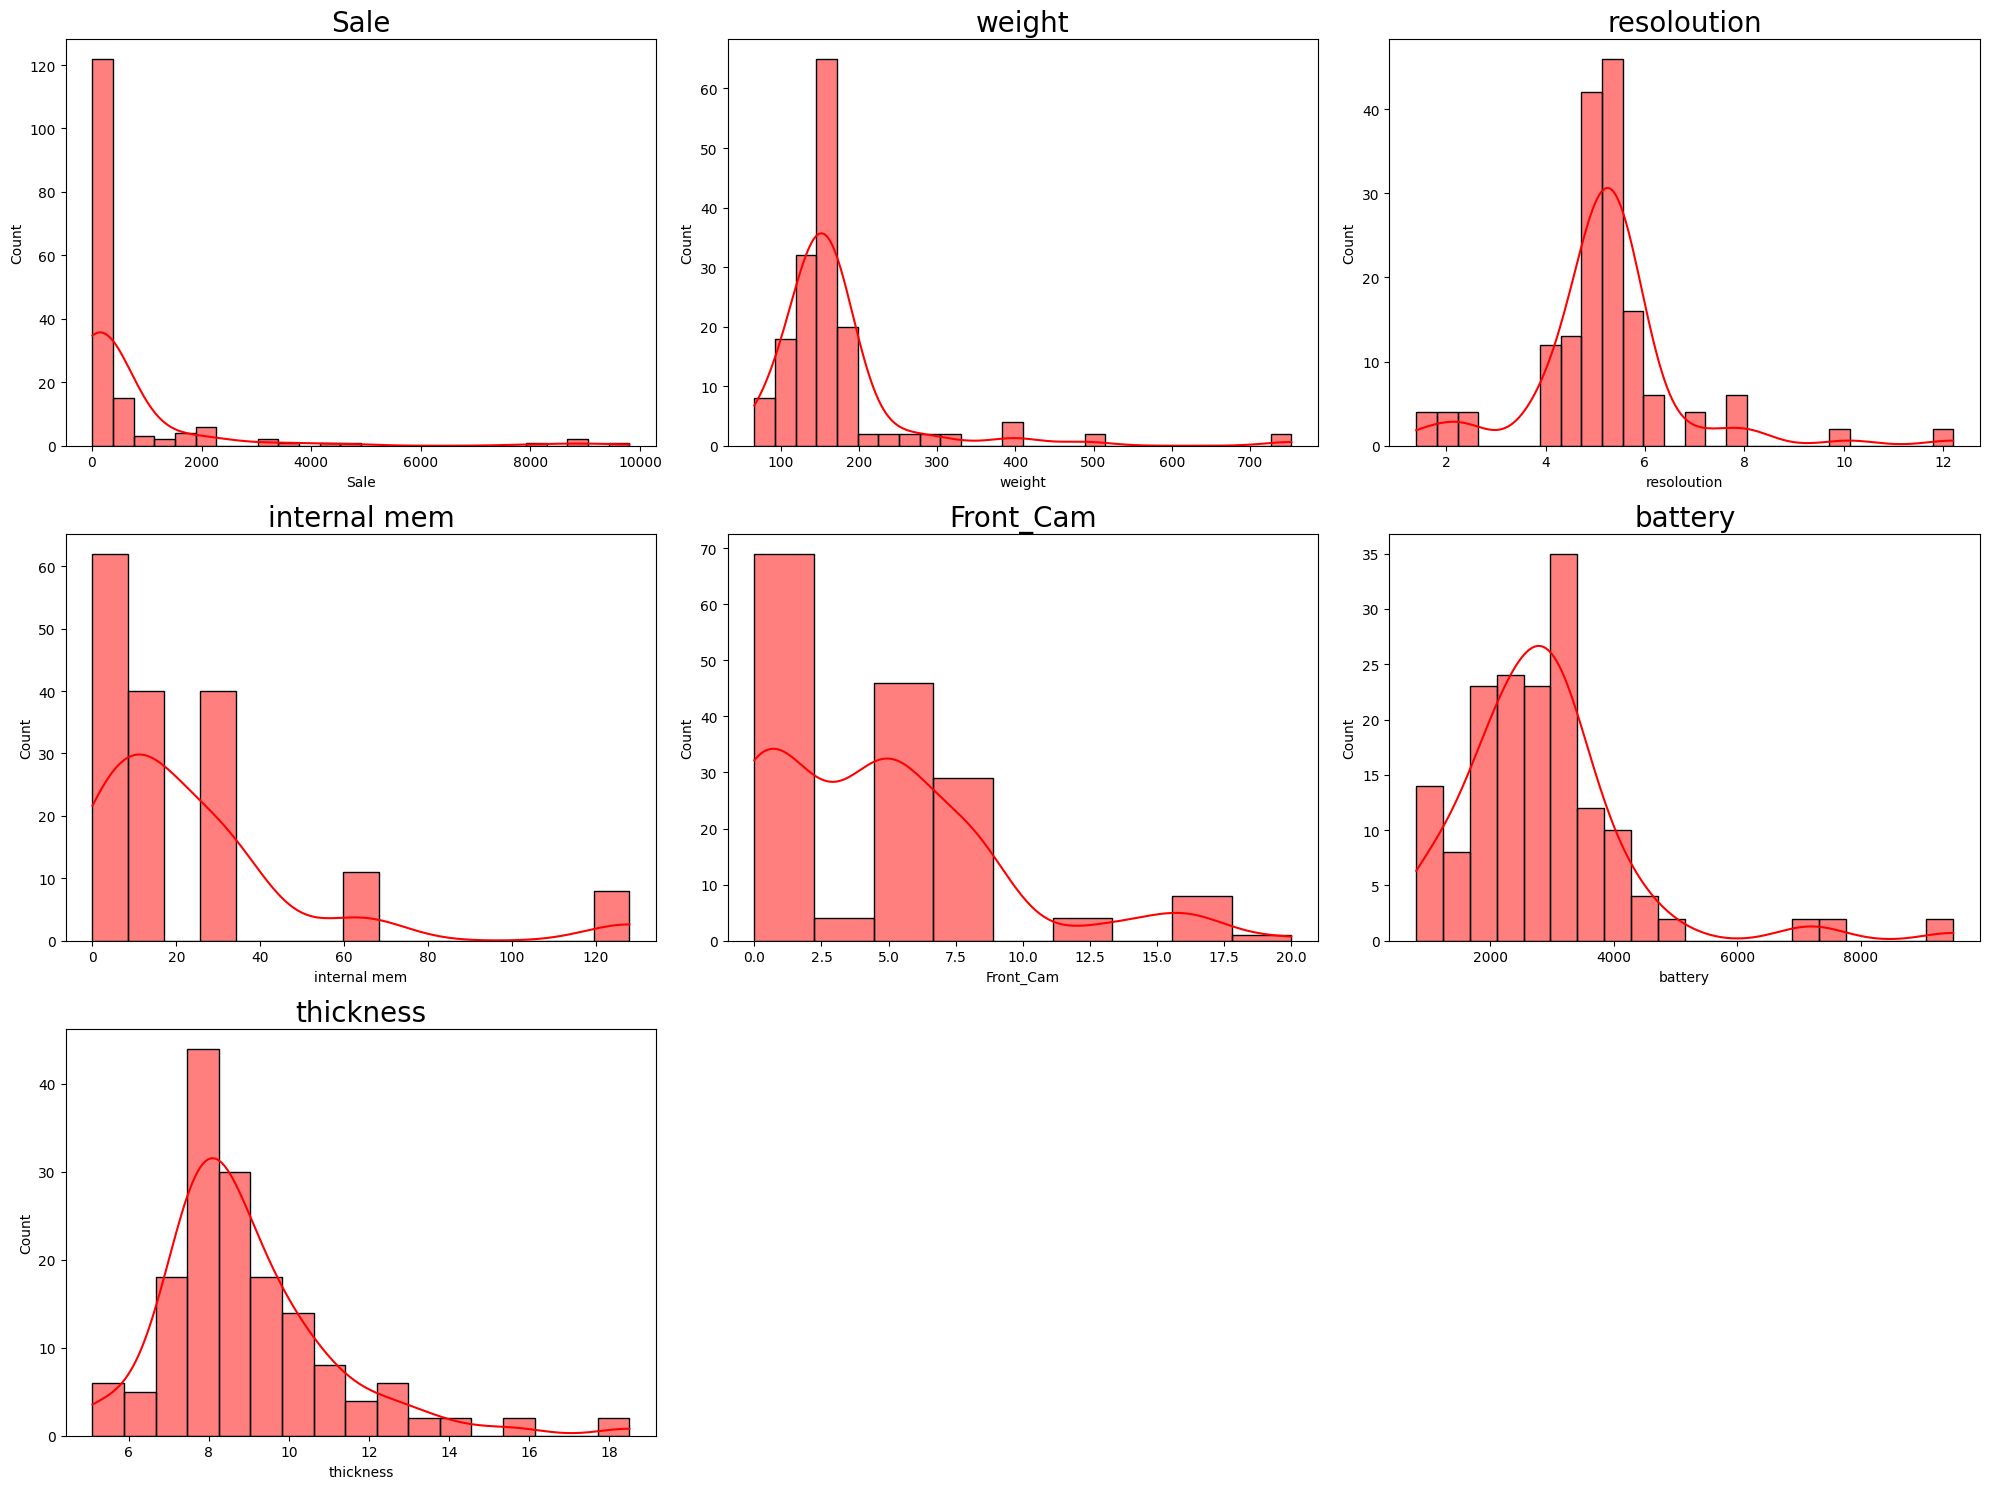

In [13]:
num_col = len(skewed_cols)
cols_per_row = 3
rows = int(np.ceil(num_col / cols_per_row))
fig,axes = plt.subplots(nrows=rows, ncols=cols_per_row,figsize=(20,5*rows))
axes= axes.flatten()

for i,col in enumerate(skewed_cols):
    sns.histplot(df[col],ax=axes[i], color='red',kde=1)
    axes[i].set_title(col, fontsize=20)

for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [14]:
#apply log transformation to skewed columns
for col in skewed_cols:
    df[col] = np.log1p(df[col])  # log1p is used to handle zero values safely

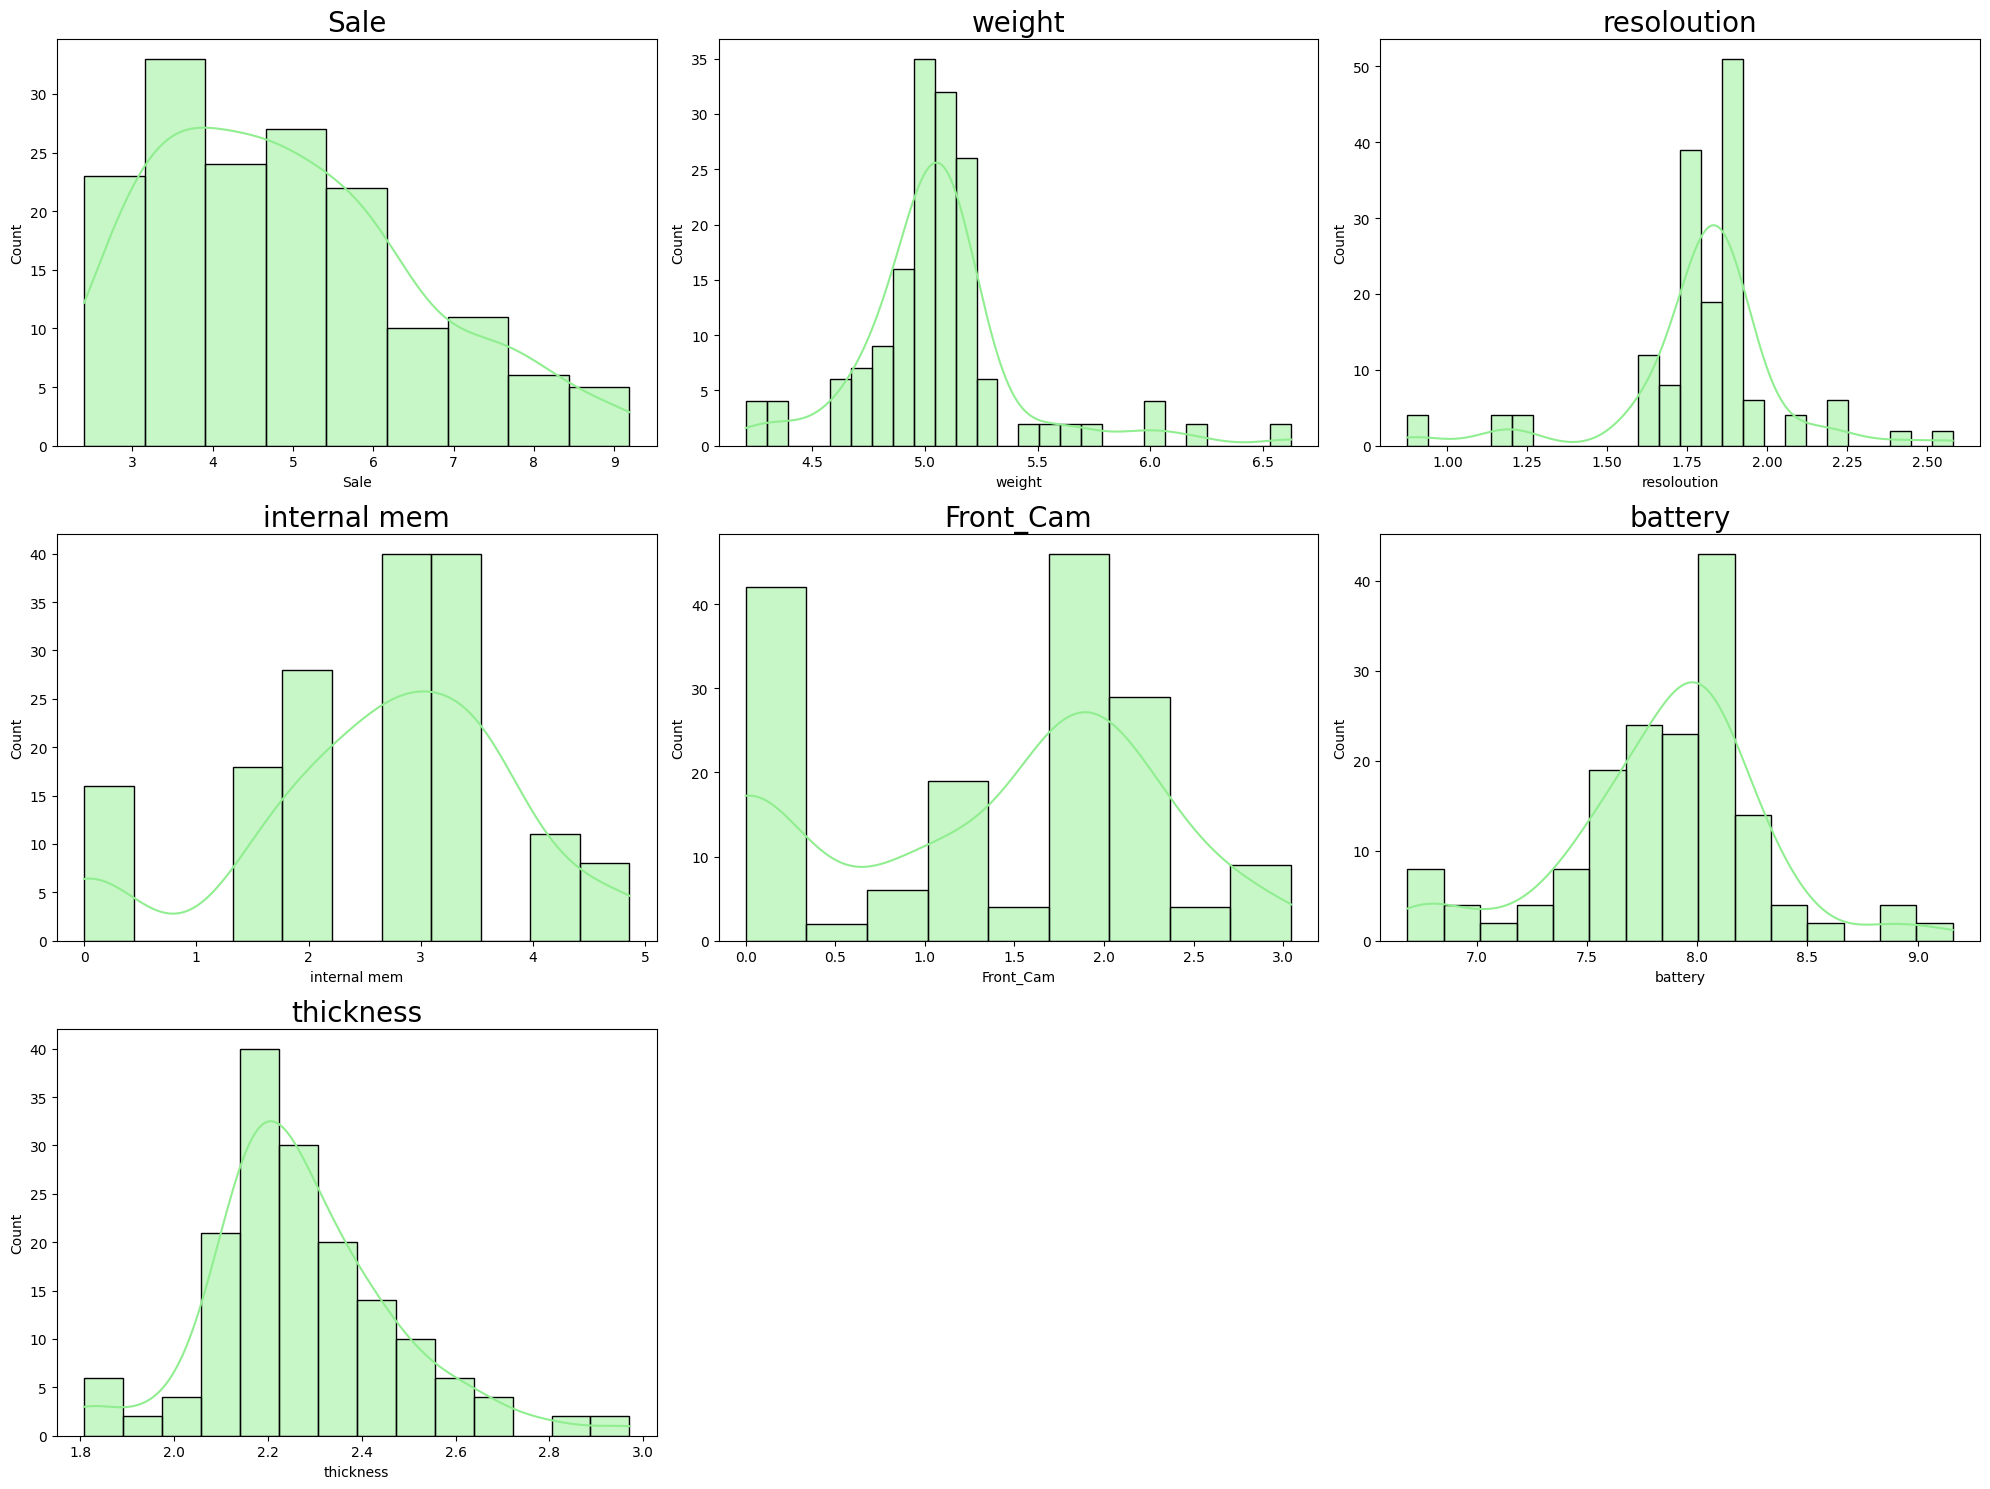

In [15]:
num_col = len(skewed_cols)
cols_per_row = 3
rows = int(np.ceil(num_col / cols_per_row))
fig,axes = plt.subplots(nrows=rows, ncols=cols_per_row,figsize=(20,5*rows))
axes= axes.flatten()

for i,col in enumerate(skewed_cols):
    sns.histplot(df[col],ax=axes[i], color='lightgreen',kde=1)
    axes[i].set_title(col, fontsize=20)

for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

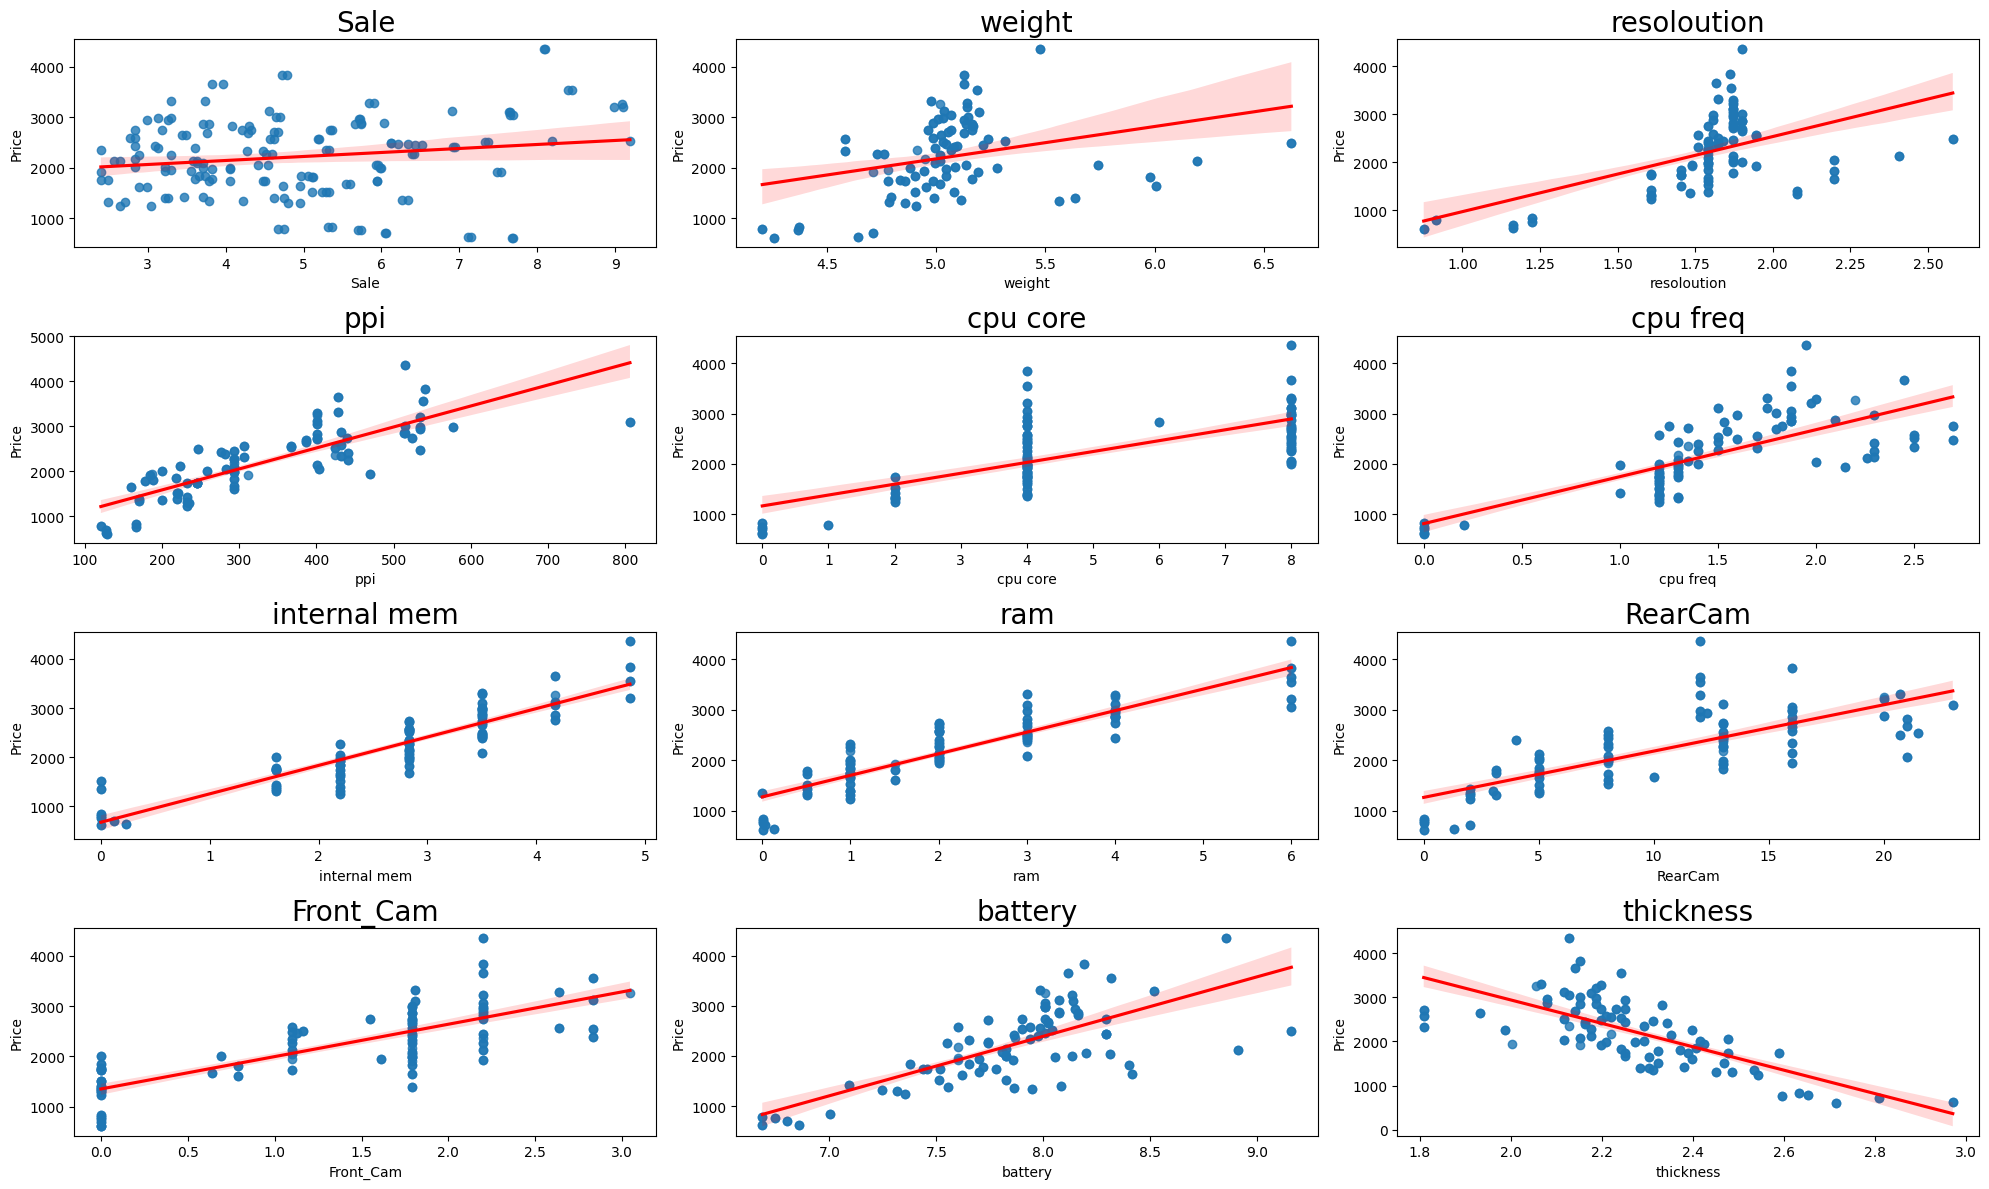

In [16]:
features = df.drop(columns=['Price'])
target = df['Price']

num_col = len(features.columns)
cols_per_row = 3
rows = int(np.ceil(num_col / cols_per_row))
fig,axes = plt.subplots(nrows=rows, ncols=cols_per_row,figsize=(20,3*rows))
axes= axes.flatten()

for i,col in enumerate(features.columns):
    sns.regplot(data=df,x=col,y='Price',ax=axes[i], line_kws={'color': 'red'} )
    axes[i].set_title(col, fontsize=20)

for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

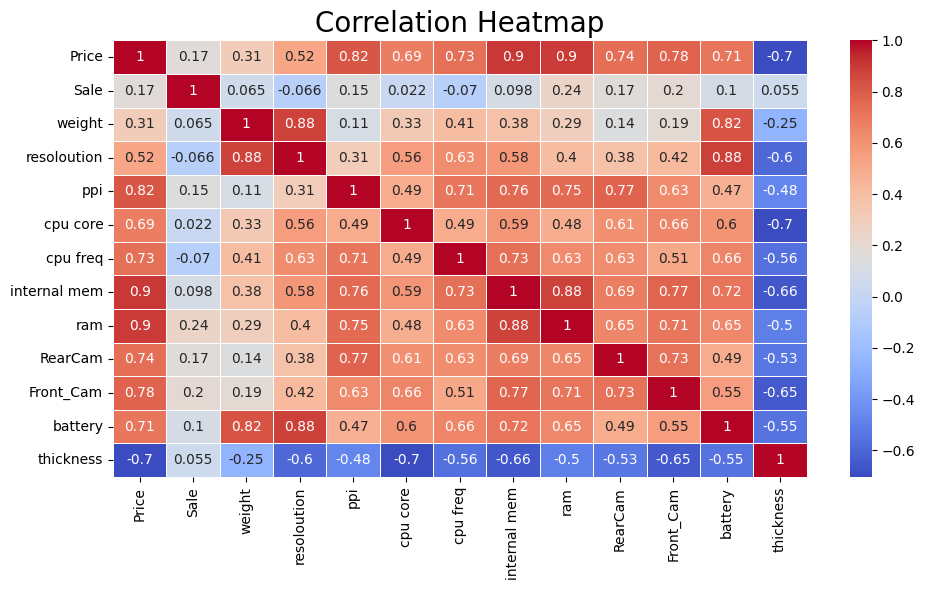

In [17]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap', fontsize=20)
plt.tight_layout()
plt.show()

In [18]:
def check_outliner(col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    return outliers

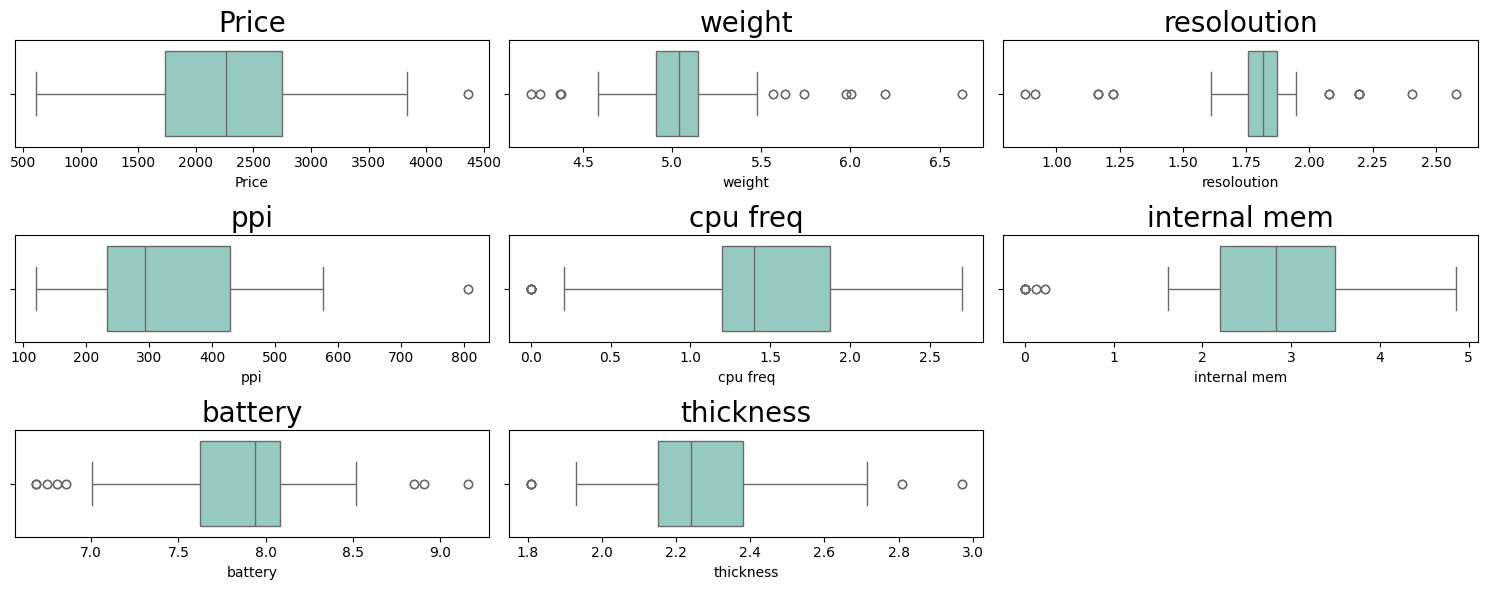

In [19]:
col_with_outliner = [col for col in df.columns if not check_outliner(col).empty]
num_col = len(col_with_outliner)
cols_per_row = 3
rows = int(np.ceil(num_col / cols_per_row))

fig,axes = plt.subplots(nrows=rows, ncols=cols_per_row,figsize=(15,2*rows))

axes= axes.flatten()

for i,col in enumerate(col_with_outliner):
    if not check_outliner(col).empty:
        sns.boxplot(df[col],ax=axes[i],orient='h', palette='Set3')
        axes[i].set_title(col, fontsize=20)

for j in range(i+1, len(axes)):
    axes[j].axis('off')  # Hide unused subplots

plt.tight_layout()
plt.show()

# For now, let's evaluate the models' performance including outliers

In [20]:
# 1. Select numeric features only
X = df.select_dtypes(include=['number'])

# 2. Create a DataFrame to store VIF values
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# 3. Calculate VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# 4. Sort and display
vif_data = vif_data.sort_values(by="VIF", ascending=False)
print(vif_data)


         feature          VIF
2         weight  2671.244686
11       battery  2077.603427
3    resoloution  1027.620475
12     thickness   540.260894
0          Price   166.672425
7   internal mem    55.019739
4            ppi    38.024242
6       cpu freq    28.083289
8            ram    23.336621
5       cpu core    15.582472
9        RearCam    14.438376
1           Sale    13.789583
10     Front_Cam    12.001488


In [21]:

# Assume df is your DataFrame and X is your feature matrix
X = df.select_dtypes(include=['number'])  # Only numeric features

# Compute VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Sort by VIF descending
print(vif_data.sort_values(by="VIF", ascending=False))


         feature          VIF
2         weight  2671.244686
11       battery  2077.603427
3    resoloution  1027.620475
12     thickness   540.260894
0          Price   166.672425
7   internal mem    55.019739
4            ppi    38.024242
6       cpu freq    28.083289
8            ram    23.336621
5       cpu core    15.582472
9        RearCam    14.438376
1           Sale    13.789583
10     Front_Cam    12.001488


In [22]:
# Assuming df is your DataFrame with features only (exclude target)
X = df.select_dtypes(include=[float, int])

# Standardize features before PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA (choose number of components, e.g., enough to explain 95% variance)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print("Original number of features:", X.shape[1])
print("Reduced number of components:", X_pca.shape[1])

# Explained variance ratio of each component
print("Explained variance ratio:", pca.explained_variance_ratio_)

# If you want to convert PCA components back to a DataFrame
pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])


Original number of features: 13
Reduced number of components: 7
Explained variance ratio: [0.58677631 0.1411315  0.0857915  0.06058466 0.03513489 0.02700641
 0.02110564]


# Model Training and Evaluation

In [23]:
# Split the dataset into features and target variable
x= df.drop(columns=['Price'])
y= df['Price']

In [24]:
#Train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.9, random_state=7)

print("Training set size:", x_train.shape[0])
print("Test set size:", x_test.shape[0])

Training set size: 144
Test set size: 17


In [25]:
#Standard Scaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)


# Models 

In [26]:
# Define models in a dictionary
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'ElasticNet Regression': ElasticNet()
}

# Empty list to collect results
results = []

# Fit and evaluate each model
for name, model in models.items():
    model.fit(x_train_scaled, y_train)
    
    # Predictions
    y_pred_train = model.predict(x_train_scaled)
    y_pred_test = model.predict(x_test_scaled)
    
    # Correct metrics
    train_mae = mean_absolute_error(y_train, y_pred_train)
    train_r2 = r2_score(y_train, y_pred_train)
    
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_r2 = r2_score(y_test, y_pred_test)
    
    # Append results
    results.append({
        'Model': name,
        'Train MAE': train_mae,
        'Train R2': train_r2,
        'Test MAE': test_mae,
        'Test R2': test_r2
    })

# Create a summary DataFrame
results_df = pd.DataFrame(results)

# Sort by Test R2 (descending)
results_df = results_df.sort_values(by='Test R2', ascending=False)

# Display
print(results_df)


                   Model   Train MAE  Train R2    Test MAE   Test R2
2       Lasso Regression  146.370033  0.943438  127.364260  0.945885
0      Linear Regression  147.520088  0.943521  128.727912  0.944412
1       Ridge Regression  146.643571  0.943460  128.699724  0.943910
3  ElasticNet Regression  161.336990  0.918074  165.068702  0.901946


# Based Upon the results, we can see that:
# - The Linear Regression model has the best performance on the test set with the lowest MSE and highest R2 score.
# - The Ridge Regression model performs well, but its MSE is slightly higher than that of the Linear Regression model.
# - The Lasso Regression model has a higher MSE compared to both Linear and Ridge Regression models, indicating that it may not be the best choice for this dataset.
# - The ElasticNet model also shows a higher MSE compared to Linear and Ridge Regression, indicating that it may not be the best choice for this dataset as well.   



In [27]:
random_model = RandomForestRegressor()
random_model.fit(x_train, y_train)

# Predictions
rf_y_pred_train = random_model.predict(x_train)
rf_y_pred_test = random_model.predict(x_test)

# Train Metrics
rf_train_mae = mean_absolute_error(y_train, rf_y_pred_train)
rf_train_r2 = r2_score(y_train, rf_y_pred_train)

print("Random Forest Train MAE:", rf_train_mae)
print("Random Forest Train R2:", rf_train_r2)

# Test Metrics
rf_test_mae = mean_absolute_error(y_test, rf_y_pred_test)
rf_test_r2 = r2_score(y_test, rf_y_pred_test)

print("Random Forest Test MAE:", rf_test_mae)
print("Random Forest Test R2:", rf_test_r2)


Random Forest Train MAE: 36.18256944444444
Random Forest Train R2: 0.9958794860095065
Random Forest Test MAE: 65.76588235294118
Random Forest Test R2: 0.9844540910012384


In [28]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='r2',         
    verbose=2,
    n_jobs=-1             
)
grid_search.fit(x_train, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best Score (CV R2):", grid_search.best_score_)
best_rf = grid_search.best_estimator_


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Score (CV R2): 0.9417512885214718


In [29]:
# Predict on training data
y_pred_train = best_rf.predict(x_train)

# Calculate training MAE and R2
train_mae = mean_absolute_error(y_train, y_pred_train)
train_r2 = r2_score(y_train, y_pred_train)

# Predict on test data
y_pred_test = best_rf.predict(x_test)

# Calculate test MAE and R2
test_mae = mean_absolute_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

# Print results
print("Best RF Train MAE:", train_mae)
print("Best RF Train R2:", train_r2)
print("Best RF Test MAE:", test_mae)
print("Best RF Test R2:", test_r2)


Best RF Train MAE: 38.617708333333326
Best RF Train R2: 0.9960408082551789
Best RF Test MAE: 65.29352941176475
Best RF Test R2: 0.985631819509907


This suggests your Random Forest model is performing really well without obvious overfitting. The test performance is very close to training performance, which is a good sign.

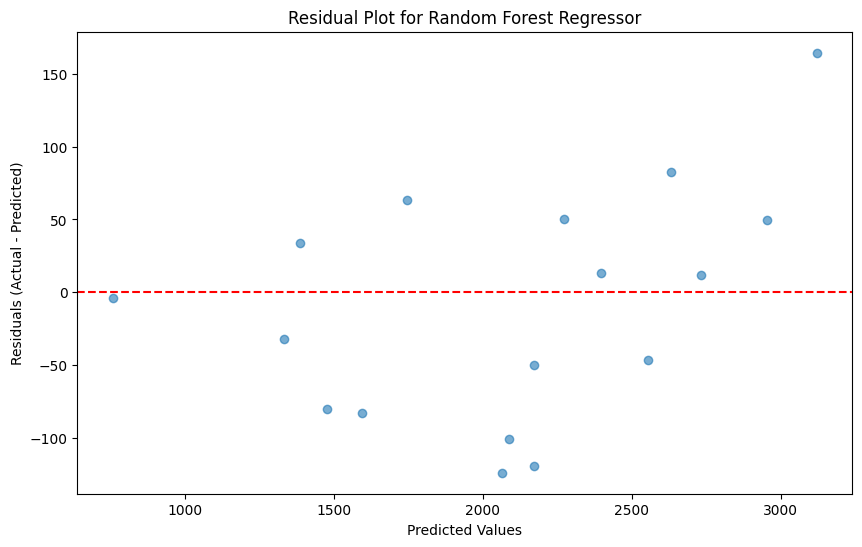

In [30]:
# Predict on test data
y_pred_test = best_rf.predict(x_test)

# Calculate residuals
residuals = y_test - y_pred_test

# Plot residuals vs predicted values
plt.figure(figsize=(10,6))
plt.scatter(y_pred_test, residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot for Random Forest Regressor')
plt.show()


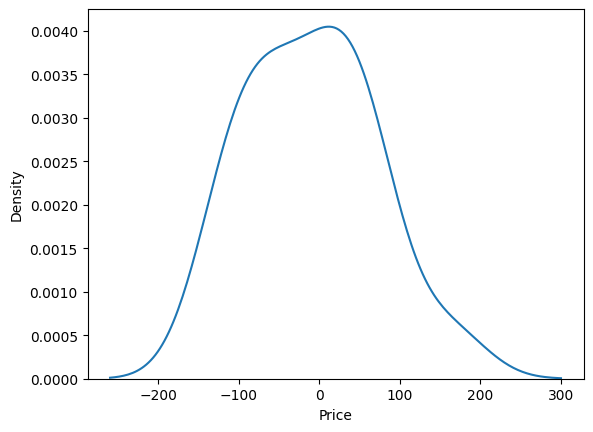

In [31]:
sns.kdeplot(residuals)
plt.show()

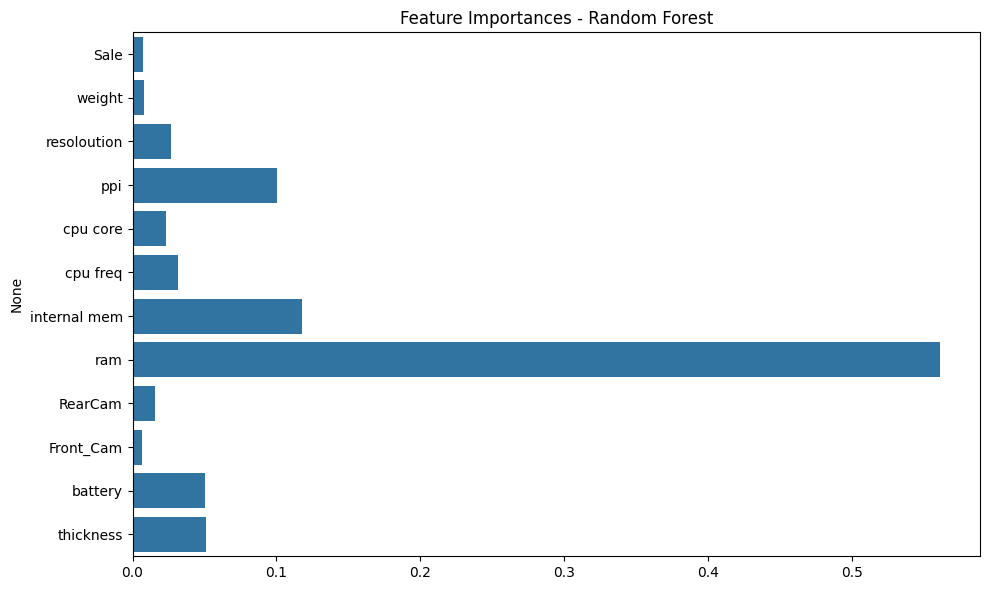

In [32]:
importances = best_rf.feature_importances_
feat_names = x.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feat_names)
plt.title("Feature Importances - Random Forest")
plt.tight_layout()
plt.show()

In [33]:
#Exporting best Model 
joblib.dump(best_rf, 'best_rf.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']